In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/improve-mie/examples/tutorials/tracking_multiple_particles_unet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Tracking multiple particles with a U-net

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.0.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

This tutorial should be perused after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [3]:
particle = dt.PointParticle(                                         
    intensity=100,
    position=lambda: np.random.rand(2) * 256
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [4]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.7,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 4. Define noises

We introduce two sources of noise (see also [noises_example](../module-examples/noises_example.ipynb)):
1. A background random offset between 0 and 1.
2. A Poisson noise with a random SNR between 3 and 10.

In [5]:
offset = dt.Add(
    value=lambda: np.random.rand()*1
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 3,
    background=offset.value
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [6]:
num_particles = lambda: np.random.randint(1, 11)

image_features = fluorescence_microscope(particle^num_particles) >> offset >> poisson_noise

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle positions, offset level, and Poisson noise). Afterwards we call the method `.plot()` to generate and display the image.

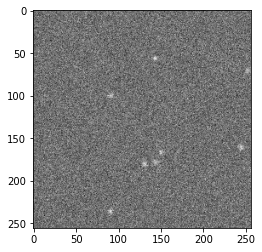

In [7]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")

## 7. Create the target images

We define a function that uses the generated images to create the target images to be used in the training. Here the target image is binary image, where each pixel is `1` if it is within `CIRCLE_RADIUS` distance from any particle in the input image, and 0 otherwise. 

In [8]:
# Creates an image with circles of radius two at the same position 
# as the particles in the input image.

CIRCLE_RADIUS = 3

def get_target_image(image_of_particles):
    target_image = np.zeros(image_of_particles.shape)
    X, Y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]), 
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]

            distance_map = (X - position[1])**2 + (Y - position[0])**2
            target_image[distance_map < CIRCLE_RADIUS**2] = 1
    
    return target_image

Here, we show images and targets side by side.

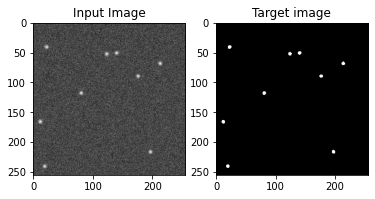

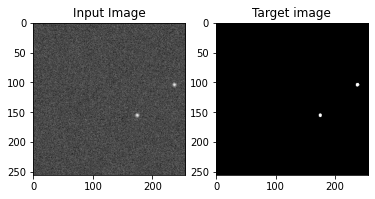

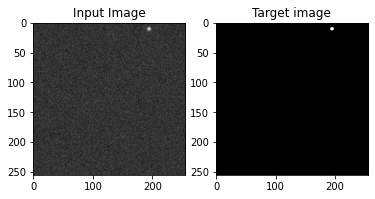

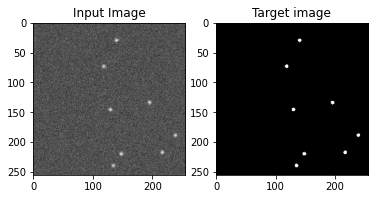

In [9]:
for i in range(4):
    image_features.update()
    image_of_particles = image_features.resolve()

    target_image = get_target_image(image_of_particles)

    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(image_of_particles), cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(target_image), cmap="gray")
    plt.title("Target image")
    
    plt.show()

## 8. Define image generator

We define a generator that creates images and targets in batches of 8.

In [10]:
generator = dt.generators.ContinuousGenerator(
    image_features, 
    get_target_image,
    batch_size=8,
    min_data_size=256,
    max_data_size=512
)

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations. We create this model by calling the function `unet` (see also [models_example](../module-examples/models_example.ipynb)).

Since the desired output is a binary image, we will be using crossentropy as loss. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than the false positives. 

The model can be customized by passing the following arguments:

* `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down-
    and upsampling.
    
* `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base
    of the unet, where the image is the most downsampled.

* `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the
    upsampling.
    
* `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling
    step.

* `number_of_outputs`: Number of convolutions in output layer.

* `output_activation`: The activation function of the output.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

In [11]:
model = dt.models.unet(
    (256, 256, 1), 
    conv_layers_dimensions=[8, 16, 32],
    base_conv_layers_dimensions=[32, 32], 
    loss=dt.losses.weighted_crossentropy((10, 1)),
    output_activation="sigmoid"
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           activation[0][0]                 
______________________________________________________________________________________________

## 10. Train the model

The model is trained by calling `.fit()`. This will take a few minutes.

In [12]:
with generator:
    model.fit(
        generator, 
        epochs=50,
    )

Generating 266 / 256 samples before starting training
Epoch 1/50
33/33 [==============================] - 6s 39ms/step - loss: 0.0484
Epoch 2/50
33/33 [==============================] - 1s 39ms/step - loss: 0.0132
Epoch 3/50
33/33 [==============================] - 1s 38ms/step - loss: 0.0105
Epoch 4/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0107
Epoch 5/50
33/33 [==============================] - 1s 25ms/step - loss: 0.0103
Epoch 6/50
33/33 [==============================] - 1s 37ms/step - loss: 0.0104
Epoch 7/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0103
Epoch 8/50
33/33 [==============================] - 1s 39ms/step - loss: 0.0094
Epoch 9/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0057
Epoch 10/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0021
Epoch 11/50
33/33 [==============================] - 1s 40ms/step - loss: 9.3511e-04
Epoch 12/50
33/33 [==============================] - 1s 38ms

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output besides the input image and the target image.

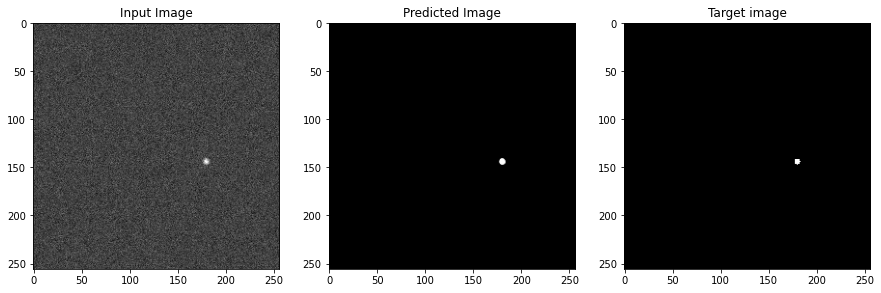

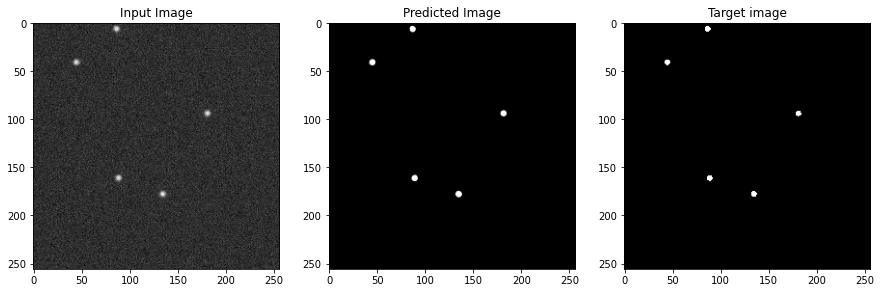

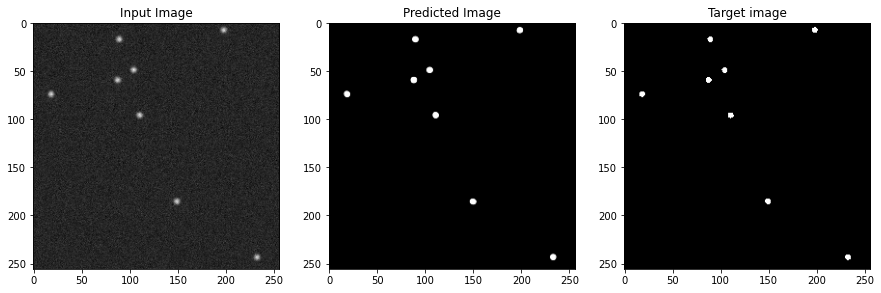

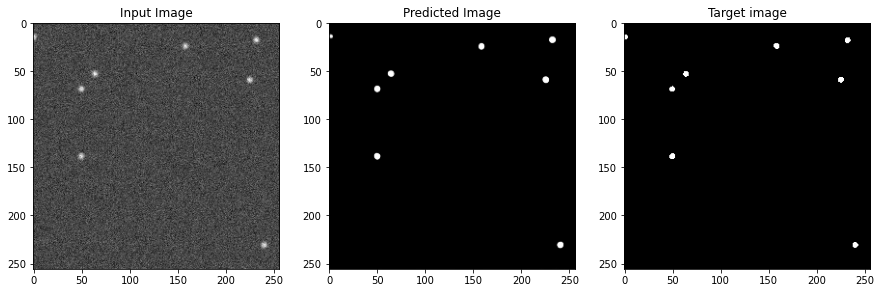

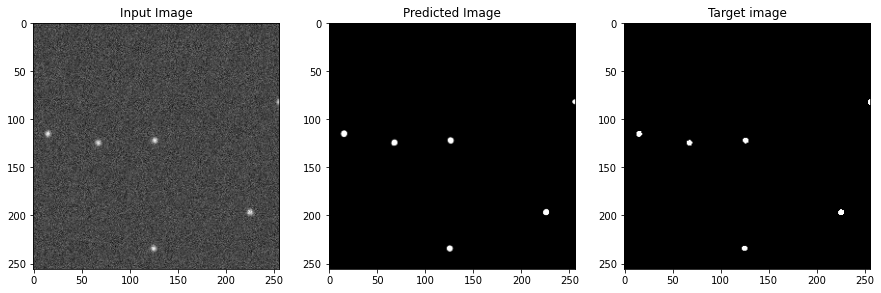

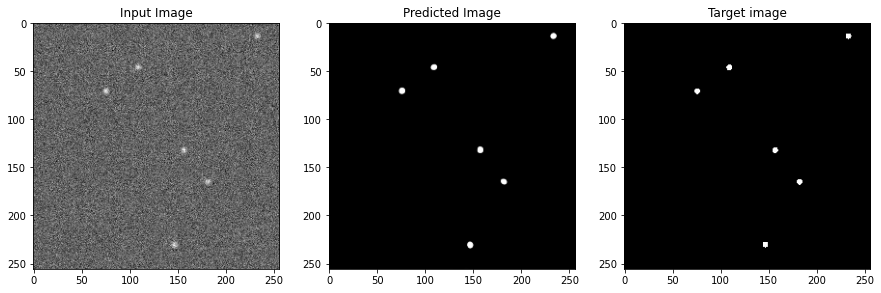

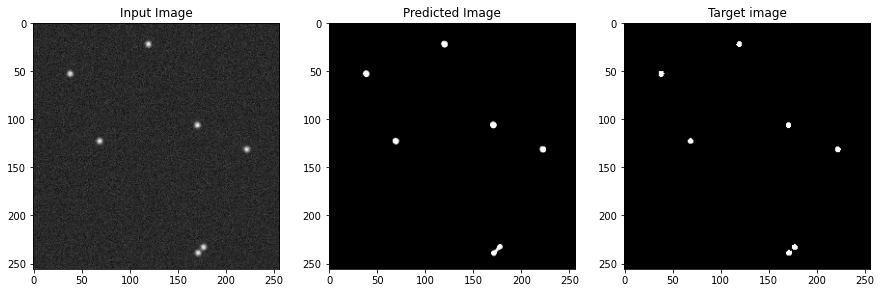

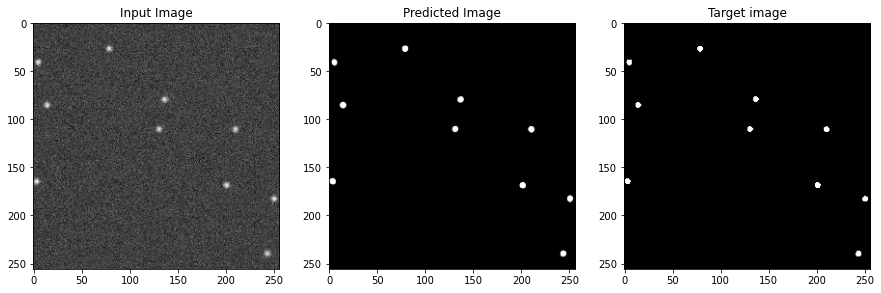

In [13]:
# generator[0] grabs a single batch from the generator
input_image, target_image = generator[0]

for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(input_image[i, :, :, 0]), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predicted_image[i, :, :, 0]), cmap="gray")
    plt.title("Predicted Image")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(target_image[i, :, :, 0] > 0.5), cmap="gray")
    plt.title("Target image")

    plt.show()